In [211]:
import pandas as pd
from datetime import timedelta
from binance.client import Client

api = 'Z0ITlKtBapUWeVbZpUCr80YemOkH7AMHKEwHFLdQy5JA8WZG9Ndlw6HudPwJPIvh'
secret = '0wQwHxsIVy0JToIXsBhmYfNDP7saGoaqADdGodwwZguPYLCAhfDHQDneZcYYwGdH'
client = Client(api, secret)

In [212]:
def spots_historical_data(symbol, interval, start_time, end_time):
    try:
        df = pd.DataFrame(client.get_historical_klines(symbol, interval, start_time, end_time))
        if df.empty:
            print(f"No data returned for {symbol}")
            return pd.DataFrame()
        df = df.iloc[:, 0:6]
        df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        df['date'] = pd.to_datetime(df['date'], unit='ms') + timedelta(hours=7)
        df['ticker'] = symbol
        return df[:-1]
    except Exception as e:
        print(f"Error fetching spot data for {symbol}: {e}")
        return pd.DataFrame()

In [213]:
df = spots_historical_data('ETHUSDT', Client.KLINE_INTERVAL_1HOUR, '2008-01-01', '2024-08-12')
df

,date,open,high,low,close,volume,ticker
0,2017-08-17 11:00:00,301.13000000,302.57000000,298.00000000,301.61000000,125.66877000,ETHUSDT
1,2017-08-17 12:00:00,301.61000000,303.28000000,300.00000000,303.10000000,377.67246000,ETHUSDT
2,2017-08-17 13:00:00,302.40000000,304.44000000,301.90000000,302.68000000,303.86672000,ETHUSDT
3,2017-08-17 14:00:00,302.68000000,307.96000000,302.60000000,307.96000000,754.74510000,ETHUSDT
4,2017-08-17 15:00:00,307.95000000,309.97000000,307.00000000,308.62000000,150.75029000,ETHUSDT
...,...,...,...,...,...,...,...
61111,2024-08-12 02:00:00,2639.12000000,2639.88000000,2596.33000000,2599.06000000,25619.49050000,ETHUSDT
61112,2024-08-12 03:00:00,2599.06000000,2602.91000000,2540.00000000,2557.41000000,34012.52850000,ETHUSDT
61113,2024-08-12 04:00:00,2557.40000000,2585.57000000,2544.11000000,2581.02000000,11949.11910000,ETHUSDT
61114,2024-08-12 05:00:00,2581.02000000,2595.21000000,2540.99000000,2567.56000000,15983.65260000,ETHUSDT


In [214]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df[['open', 'high', 'low', 'close', 'volume']]
df.to_csv('eth_spots_1hour.csv')

In [215]:
import pandas as pd
import numpy as np

i

In [216]:
df = pd.read_csv('eth_spots_1hour.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['ret'] = df['close'].pct_change()
df['price'] = df.open.shift(-1)
df

,open,high,low,close,volume,ret,price
date,,,,,,,
2017-08-17 11:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,301.61
2017-08-17 12:00:00,301.61,303.28,300.00,303.10,377.67246,0.004940,302.40
2017-08-17 13:00:00,302.40,304.44,301.90,302.68,303.86672,-0.001386,302.68
2017-08-17 14:00:00,302.68,307.96,302.60,307.96,754.74510,0.017444,307.95
2017-08-17 15:00:00,307.95,309.97,307.00,308.62,150.75029,0.002143,308.62
...,...,...,...,...,...,...,...
2024-08-12 02:00:00,2639.12,2639.88,2596.33,2599.06,25619.49050,-0.015176,2599.06
2024-08-12 03:00:00,2599.06,2602.91,2540.00,2557.41,34012.52850,-0.016025,2557.40
2024-08-12 04:00:00,2557.40,2585.57,2544.11,2581.02,11949.11910,0.009232,2581.02


In [191]:
train = df.iloc[:-15000]
test = df.iloc[-15000:]

In [192]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    if cum_ret.max() == 0:
        max_dd = np.nan
    else:
        max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

Train Sharpe: -0.3844689385475553, Max Drawdown: 1100.8810572687216%


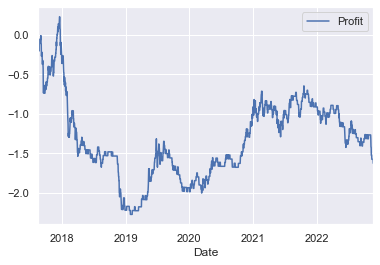

In [206]:
in_position = False
profits = []
profit_dates = []
for index, row in train.iterrows():
    if not in_position:
        if row.ret > 0.01:
            buy_price = row.price
            bought_at = index
            tp = buy_price * 1.05
            sl = buy_price * 0.95
            in_position = True
    if in_position and index > bought_at:
        if row.high > tp:
            profit = (tp - buy_price) / buy_price - 0.001
            profit_dates.append(index)
            profits.append(profit)
            in_position = False
        elif row.low < sl:
            profit = (sl - buy_price) / buy_price - 0.001
            profit_dates.append(index)
            profits.append(profit)
            in_position = False

train_pf = pd.DataFrame({
    'Date': profit_dates,
    'Profit': profits
}).set_index('Date')

daily_pnl = train_pf.resample('D').sum()
daily_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(daily_pnl.Profit)
print(f"Train Sharpe: {sharpe}, Max Drawdown: {max_dd}%")

Train Sharpe: 1.5400800012311329, Max Drawdown: 15.625000000000025%


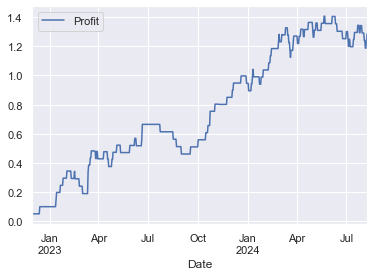

In [210]:
in_position = False
profits = []
profit_dates = []
for index, row in test.iterrows():
    if not in_position:
        if row.ret > 0.01:
            buy_price = row.price
            bought_at = index
            tp = buy_price * 1.05
            sl = buy_price * 0.95
            in_position = True
    if in_position and index > bought_at:
        if row.high > tp:
            profit = (tp - buy_price) / buy_price - 0.001
            profit_dates.append(index)
            profits.append(profit)
            in_position = False
        elif row.low < sl:
            profit = (sl - buy_price) / buy_price - 0.001
            profit_dates.append(index)
            profits.append(profit)
            in_position = False

test_pf = pd.DataFrame({
    'Date': profit_dates,
    'Profit': profits
}).set_index('Date')

daily_pnl = test_pf.resample('D').sum()
daily_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(daily_pnl.Profit)
print(f"Train Sharpe: {sharpe}, Max Drawdown: {max_dd}%")